In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import os, gc, math, sys, re
import os,sys
import numpy as np
import logging
import pandas as pd
import time
import threading
import copy as cp

from tqdm import *
from datetime import datetime as dt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
log_filename = format(dt.today(), 'log_research_2-%Y-%m-%d.log')
logging.basicConfig(format='[%(asctime)s]  %(message)s', level=logging.DEBUG,
                    filename=os.path.join('..', log_filename))
logging.info('RESEARCH log file')

In [4]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
matplotlib.rc('font', family='DejaVu Sans')
%matplotlib inline

In [5]:
with open('../preproc_df.pkl', 'rb') as f:
    df = pkl.load(f)

In [6]:
def show_nulls(data):
    d = ((c, data[c][pd.isnull(data[c])].shape[0]) for c in data.columns)
    return pd.DataFrame(d, columns=['name', 'nans'])

In [7]:
def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred)) / pd.Series(y_true))) * 100.

def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])

    

In [8]:
features = list(df.columns[14:19]) + list(df.columns[22:])
target = 'time_of_expected'

In [9]:
print min(df.Arrive), ' - ', max(df.Arrive)
print min(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive)
print min(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive)

2014-04-07 06:48:00  -  2016-11-16 16:20:49
2015-01-02 06:58:00  -  2015-04-10 17:49:00
2014-04-07 06:48:00  -  2016-11-16 16:20:49


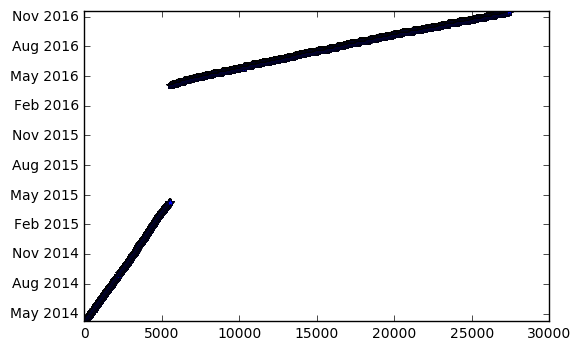

In [10]:
plt.plot(range(df.shape[0]), sorted(df.Arrive), '*')

In [11]:
df = df.sort_values('time_of_expected')
df = df[5:df.shape[0]-5]

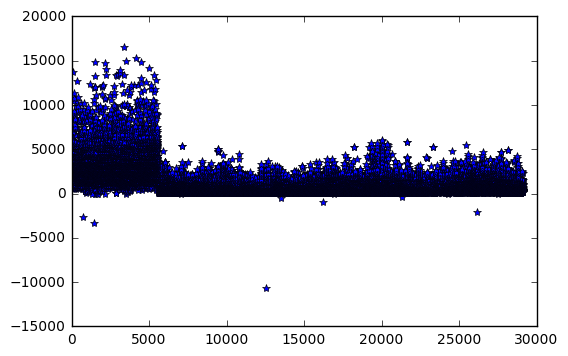

In [12]:
plt.plot(df.time_of_expected, '*')

In [13]:
date_threshold_val_low_1 = datetime.strptime('15.03.2015','%d.%m.%Y')
date_threshold_val_up_1 = datetime.strptime('01.04.2015','%d.%m.%Y')

date_threshold_val_low_2 = datetime.strptime('01.10.2016','%d.%m.%Y')
date_threshold_val_up_2 = datetime.strptime('01.11.2016','%d.%m.%Y')

date_threshold_test_low_1 = datetime.strptime('02.04.2015','%d.%m.%Y')
date_threshold_test_up_1 = datetime.strptime('15.08.2015','%d.%m.%Y')

date_threshold_test_low_2 = datetime.strptime('02.11.2016','%d.%m.%Y')
date_threshold_test_up_2 = datetime.strptime('21.01.2017','%d.%m.%Y')

val_cond = ( (df.Arrive >= date_threshold_val_low_1) & (df.Arrive <= date_threshold_val_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_val_low_2) & (df.Arrive <= date_threshold_val_up_2))
test_cond = ( (df.Arrive >= date_threshold_test_low_1) & (df.Arrive <= date_threshold_test_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_test_low_2) & (df.Arrive <= date_threshold_test_up_2))

test = df[test_cond].reset_index(drop=True)    
val = df[val_cond].reset_index(drop=True)
train = df[map(lambda x,y: not (x or y), test_cond, val_cond)].reset_index(drop=True)

In [14]:
print train.shape[0]
print val.shape[0]
print test.shape[0]

22529
3371
1514


In [15]:
with open('../train_val_test_split.pkl', 'wb') as f:
    pkl.dump([train, val, test], f)

#### Посмотрим, какие признаки будут выбираться с помощью методов фильтрации

In [16]:
def mrmr(matrix, feature_select, feature_candidate, ind_target):
    temp = [i[0] for i in feature_select] + [feature_candidate]
    
    part_1 = 0
    for ind, feat in temp:
        part_1 = part_1 + matrix[ind, ind_target]
    part_1 = part_1*1./len(temp)
    
    part_2 = 0
    for ind_1 in range(len(temp)):
        for ind_2 in range(ind_1+1,len(temp)):
            part_2 = part_2 + matrix[ind_1, ind_2]
    part_2 = part_2*1./len(temp)/len(temp)
    
    return part_1 - part_2

In [17]:
features_select = []
matrix = np.corrcoef(df[features + [target]].values.T)
ind_target = matrix.shape[0]-1

# iter 0
res = []
for ind, feat in enumerate(features):
    res.append(((ind, feat), matrix[ind, ind_target]))
res_sorted = sorted(res, key=lambda x: x[0][1], reverse=True)
features_select.append(res_sorted[0])

# next iter
while len(features) != len(features_select):
    res = []
    for ind, feat in enumerate(features):
        if feat not in [f_[0][1] for f_ in features_select]:
            res.append(((ind, feat), mrmr(matrix, features_select, (ind, feat), ind_target)))
    res_sorted = sorted(res, key=lambda x: x[0][1], reverse=True)
    features_select.append(res_sorted[0])

#### Мы получили список признаков, отранжированных по увеличению влияния на mrmr
Далее попробуем строить наши модели, последовательно добавляя признаки из списка

In [78]:
def my_r2(y_real, y_pred):
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)
    up = (np.multiply(y_real-y_pred, y_real-y_pred).sum())
    down = (np.multiply(y_real-np.mean(y_real), y_real-np.mean(y_real)).sum())
    return 1 - up*1./down

In [32]:
from sklearn.preprocessing import StandardScaler

In [51]:
def test_model_on_sorted_features(model, scaler, train, val, features_select, scores):
    res = {}
    for i in tqdm(range(1,len(features_select))):
        temp_feat = [j[0][1] for j in features_select[:i]]
        data = scaler.fit_transform(train[temp_feat].values)
        model.fit(data, train[target])
        y_pred = model.predict(scaler.transform(val[temp_feat].values))
        y_real = val[target]
        sc = {}
        for score in scores:
            sc[score] = scores[score](y_real, y_pred)    
        res[i] = sc
    return res

In [52]:
result_LR = test_model_on_sorted_features(LinearRegression(), 
                                          StandardScaler(),
                                          train, 
                                          val, 
                                          features_select, 
                                          { 'r2':lambda x,y: -r2_score(x,y),
                                            'mape':lambda x,y: mape(x,y),
                                            'mse':lambda x,y: mean_squared_error(x,y),
                                            'mae':lambda x,y: mean_absolute_error(x,y),
                                          })

100%|██████████| 422/422 [03:14<00:00,  1.06s/it]


In [53]:
result_LassoR = test_model_on_sorted_features(Lasso(), 
                                              StandardScaler(),
                                              train,
                                              val,
                                              features_select, 
                                              { 'r2':lambda x,y: -r2_score(x,y),
                                                'mape':lambda x,y: mape(x,y),
                                                'mse':lambda x,y: mean_squared_error(x,y),
                                                'mae':lambda x,y: mean_absolute_error(x,y),
                                              })

100%|██████████| 422/422 [58:21<00:00, 20.61s/it]


In [54]:
result_RidgeR = test_model_on_sorted_features(Ridge(), 
                                              StandardScaler(),
                                              train,
                                              val,
                                              features_select, 
                                              { 'r2':lambda x,y: -r2_score(x,y),
                                                'mape':lambda x,y: mape(x,y),
                                                'mse':lambda x,y: mean_squared_error(x,y),
                                                'mae':lambda x,y: mean_absolute_error(x,y),
                                              })

100%|██████████| 422/422 [01:34<00:00,  1.98it/s]


Linear Regression


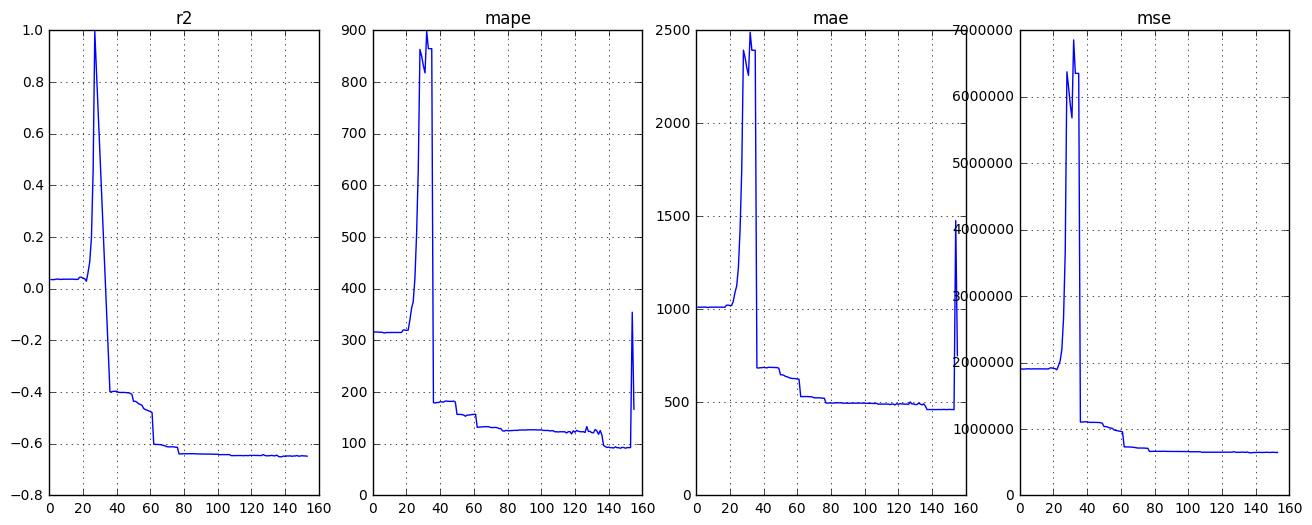

In [88]:
print 'Linear Regression'
plt.figure(figsize=[16,6])
plt.subplot(141)
plt.plot([i for i,j in zip(result_LR.keys(),result_LR.values()) if j['r2'] < 1],
         [i['r2'] for i in result_LR.values() if i['r2'] < 1])
plt.grid(True)
plt.title('r2')
plt.subplot(142)
plt.plot([i for i,j in zip(result_LR.keys(),result_LR.values())[:155] if j['r2']],
         [i['mape'] for i in result_LR.values()[:155] if i['mape']])
plt.grid(True)
plt.title('mape')
plt.subplot(143)
plt.plot([i for i,j in zip(result_LR.keys(),result_LR.values())[:155] if j['r2']],
         [i['mae'] for i in result_LR.values()[:155] if i['mae']])
plt.grid(True)
plt.title('mae')
plt.subplot(144)
plt.plot([i for i,j in zip(result_LR.keys(),result_LR.values())[:153] if j['r2']],
         [i['mse'] for i in result_LR.values()[:153] if i['mse']])
plt.grid(True)
plt.title('mse')

Lasso Regression


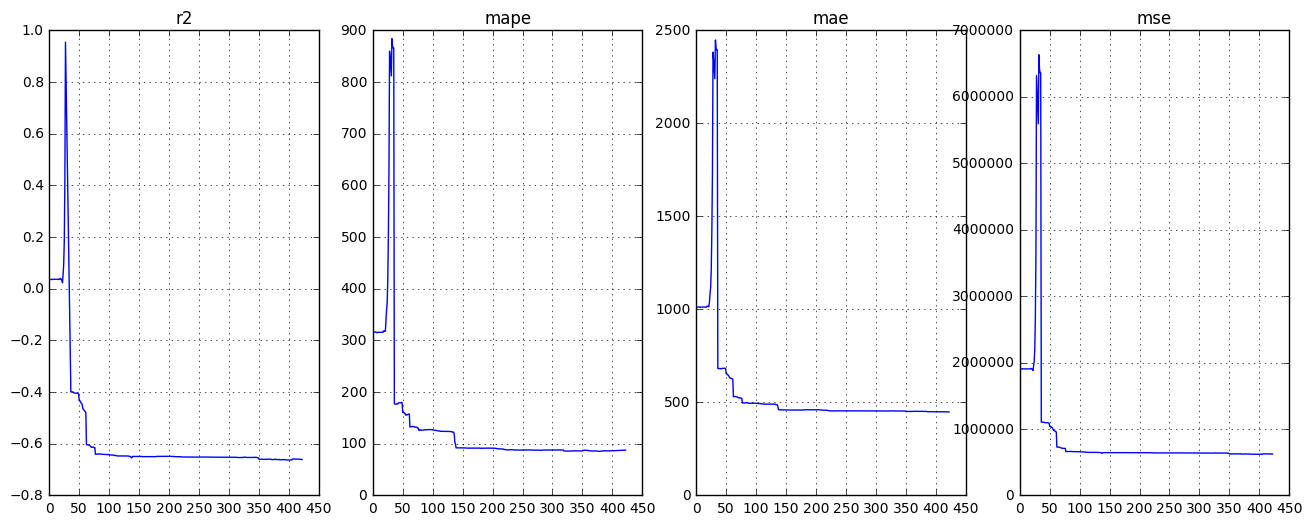

In [91]:
print 'Lasso Regression'
plt.figure(figsize=[16,6])
plt.subplot(141)
plt.plot([i for i,j in zip(result_LassoR.keys(),result_LassoR.values()) if j['r2'] < 1],
         [i['r2'] for i in result_LassoR.values() if i['r2'] < 1])
plt.grid(True)
plt.title('r2')
plt.subplot(142)
plt.plot([i for i,j in zip(result_LassoR.keys(),result_LassoR.values())[:] if j['r2']],
         [i['mape'] for i in result_LassoR.values()[:] if i['mape']])
plt.grid(True)
plt.title('mape')
plt.subplot(143)
plt.plot([i for i,j in zip(result_LassoR.keys(),result_LassoR.values())[:] if j['r2']],
         [i['mae'] for i in result_LassoR.values()[:] if i['mae']])
plt.grid(True)
plt.title('mae')
plt.subplot(144)
plt.plot([i for i,j in zip(result_LassoR.keys(),result_LassoR.values())[:] if j['r2']],
         [i['mse'] for i in result_LassoR.values()[:] if i['mse']])
plt.grid(True)
plt.title('mse')

Ridge Regression


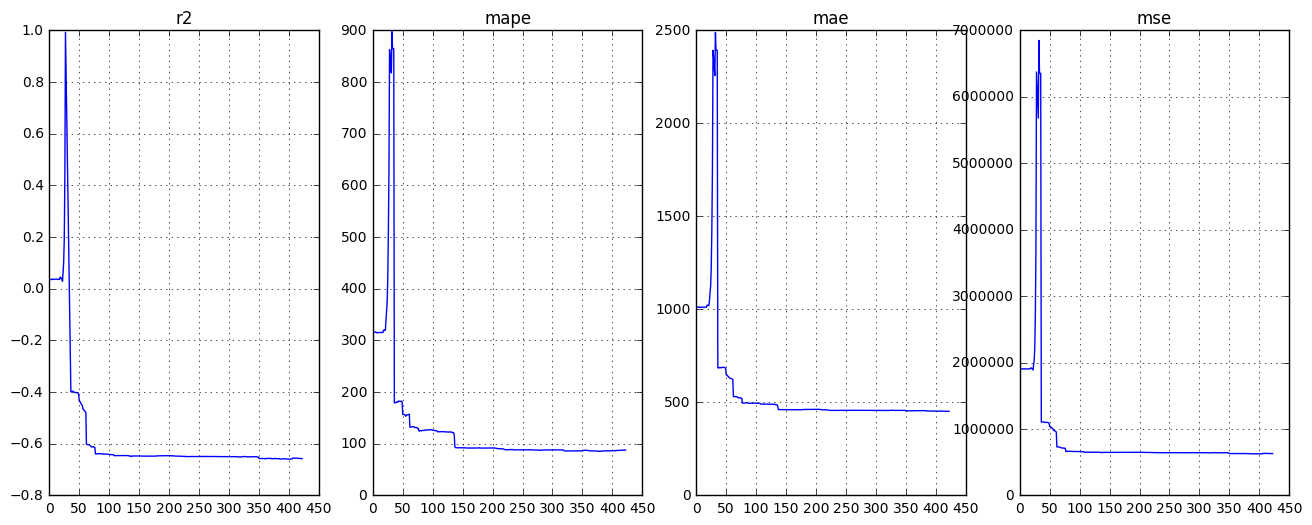

In [92]:
print 'Ridge Regression'
plt.figure(figsize=[16,6])
plt.subplot(141)
plt.plot([i for i,j in zip(result_RidgeR.keys(),result_RidgeR.values()) if j['r2'] < 1],
         [i['r2'] for i in result_RidgeR.values() if i['r2'] < 1])
plt.grid(True)
plt.title('r2')
plt.subplot(142)
plt.plot([i for i,j in zip(result_RidgeR.keys(),result_RidgeR.values())[:] if j['r2']],
         [i['mape'] for i in result_RidgeR.values()[:] if i['mape']])
plt.grid(True)
plt.title('mape')
plt.subplot(143)
plt.plot([i for i,j in zip(result_RidgeR.keys(),result_RidgeR.values())[:] if j['r2']],
         [i['mae'] for i in result_RidgeR.values()[:] if i['mae']])
plt.grid(True)
plt.title('mae')
plt.subplot(144)
plt.plot([i for i,j in zip(result_RidgeR.keys(),result_RidgeR.values())[:] if j['r2']],
         [i['mse'] for i in result_RidgeR.values()[:] if i['mse']])
plt.grid(True)
plt.title('mse')